In [193]:
import finesse
finesse.configure(plotting=True)
sm=finesse.Model()
sm.parse("""
l laser1 P=1 
s s0 laser1.p1 pr.p1 L=0
#mod Pm midx=1 f=9M order=1
#s s1 Pm.p2 pr.p1 L=0
m pr R=0.9 T=0.1    #Power recycling mirror
s PRC pr.p2 bs1.p1 L=1
bs bs1 R=0.5 T=0.5  #50-50 Beam Splitter
s Lx bs1.p3 ETMx.p1 L=1+266E-9   #Impedance matched(R_pr=sin^2(k(lx-ly)))
m ETMx R=1 T=0 phi=90                    #Setting the asymmetric port dark

s Ly bs1.p2 ETMy.p1 L=1
m ETMy R=1 T=0 
pd Circulated_p bs1.p1.i       #Power circulated in the Power recycling cavity
ad Circulated_f bs1.p1.i f=0    #CField circulated in the PRC
#ad Circulated_s1 bs1.p1.i f=9M  #SField circulated in the PRC
#ad Circulated_s2 bs1.p1.i f=-9M   #SField circulated in the PRC
xaxis(bs1.phi,lin,0,90,100)
""")

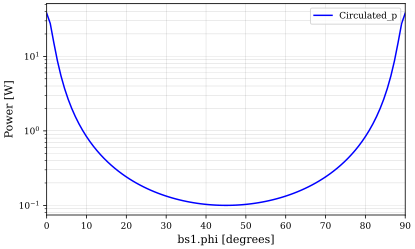

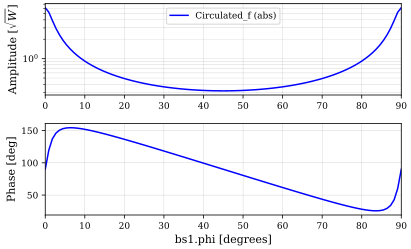

{finesse.detectors.powerdetector.PowerDetector: <Figure size 576x355.968 with 1 Axes>,
 'Circulated_p': <Figure size 576x355.968 with 1 Axes>,
 finesse.detectors.amplitude_detector.AmplitudeDetector: <Figure size 576x355.968 with 2 Axes>,
 'Circulated_f': <Figure size 576x355.968 with 2 Axes>}

In [194]:
out=sm.run()
out.plot(logy=True)
#circulated=[]
# for i in range(10001):
#     circulated.append(out["Circulated"][i])

In [62]:
# b=[]
# for i in range(10001):
#     if abs(circulated[i]-0.5*max(circulated))<0.15:#approximating the FWHM by finding two points close to the half maximum
#         b.append(circulated[i])
# print(b)

In [63]:
# print("FWHM_pr={}Hz".format(1E4*(circulated.index(b[1])-circulated.index(b[0]))))
# print("FSR_pr={}Hz".format(1.5E8))
# print("FINESSE_pr={}".format(1.5E8/(1E4*(circulated.index(b[1])-circulated.index(b[0])))))